In [1]:
!pip install evaluate
!pip install sentence_transformers
!pip install faiss-cpu
!pip install rouge_score
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 60.5 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a42fcbdfdc71e9c064a7f119301596494c996554a09c358fec165eed1edacdcb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

(…)t_Training_Dataset_27K_responses-v11.csv:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

Số lượng giá trị trống trong tập huấn luyện:
 flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64
Số lượng giá trị trống trong tập kiểm thử:
 flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


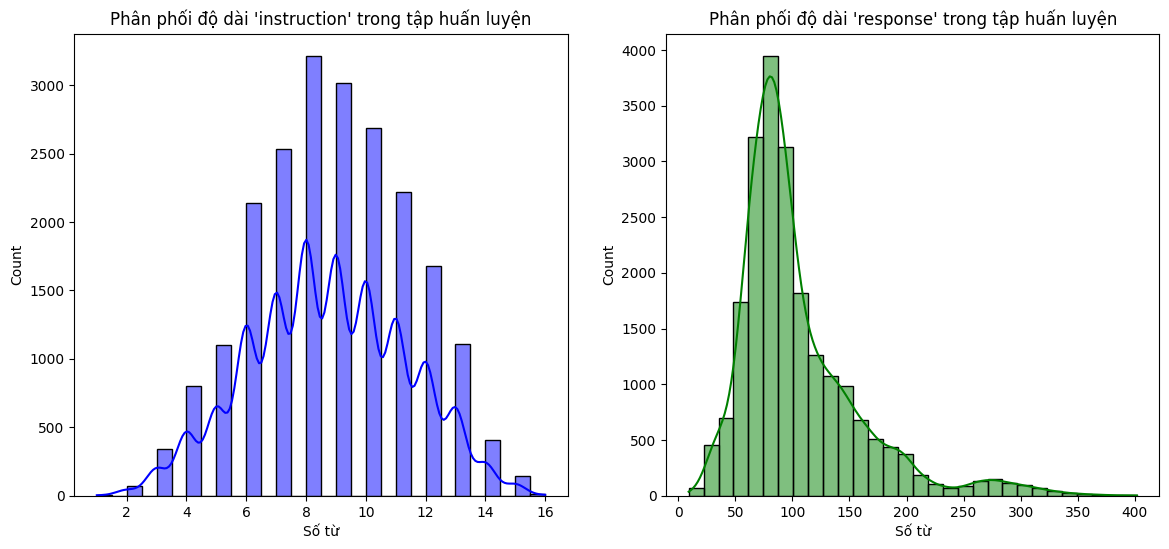


Phân phối các loại intent trong tập huấn luyện:
intent
delivery_period             3.819138
payment_issue               3.791227
check_refund_policy         3.777271
set_up_shipping_address     3.772619
registration_problems       3.772619
get_refund                  3.763316
contact_customer_service    3.754012
switch_account              3.735405
delete_account              3.735405
place_order                 3.726101
complaint                   3.721450
track_order                 3.702842
get_invoice                 3.702842
check_invoice               3.702842
change_order                3.698190
track_refund                3.688887
check_payment_methods       3.684235
delivery_options            3.679583
edit_account                3.670280
recover_password            3.665628
review                      3.660976
newsletter_subscription     3.651672
cancel_order                3.637717
change_shipping_address     3.637717
create_account              3.637717
contact_human_agent

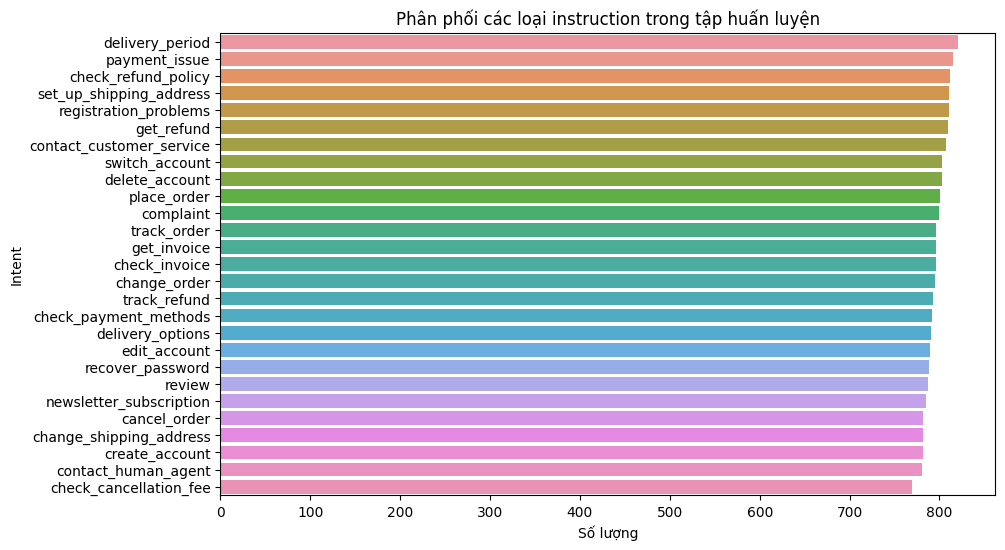


Một vài mẫu dữ liệu trong tập huấn luyện:


,instruction,response
8605,where could i cancel mycorporate newsletter su...,I see that you're looking for information on h...
6072,shiping to {{Delivery City}},Sure! We are excited to offer our delivery ser...
9208,"I need to look for my invoice #00108, help me",Absolutely! I'm here to assist you with locati...
8823,refund {{Refund Amount}} dollars,I've noticed that you are seeking a refund of ...
9525,want help to edit some of the details on my ac...,How astounding it is to witness your desire fo...


In [2]:
import asyncio
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import torch
import os
import faiss
import pandas as pd
import evaluate
import random
import shutil
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.amp import autocast, GradScaler


# Cấu hình thiết bị và biến môi trường cho multi-GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Sử dụng 2 GPU đầu tiên
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Tải dataset và chuẩn bị tập huấn luyện và tập kiểm thử
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Chuyển đổi dữ liệu thành DataFrame để dễ xử lý
train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

# Kiểm tra các cột và giá trị trống
print("Số lượng giá trị trống trong tập huấn luyện:\n", train_df.isnull().sum())
print("Số lượng giá trị trống trong tập kiểm thử:\n", eval_df.isnull().sum())

train_df['instruction_length'] = train_df['instruction'].apply(lambda x: len(x.split()))
train_df['response_length'] = train_df['response'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['instruction_length'], kde=True, color="blue", bins=30)
plt.title("Phân phối độ dài 'instruction' trong tập huấn luyện")
plt.xlabel("Số từ")

plt.subplot(1, 2, 2)
sns.histplot(train_df['response_length'], kde=True, color="green", bins=30)
plt.title("Phân phối độ dài 'response' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.show()

# Tỉ lệ phân loại 'intent' nếu có nhiều loại ý định
if 'instruction' in train_df.columns:
    print("\nPhân phối các loại intent trong tập huấn luyện:")
    print(train_df['intent'].value_counts(normalize=True) * 100)
    
    # Vẽ biểu đồ tỉ lệ các loại instruction
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_df, y='intent', order=train_df['intent'].value_counts().index)
    plt.title("Phân phối các loại instruction trong tập huấn luyện")
    plt.xlabel("Số lượng")
    plt.ylabel("Intent")
    plt.show()
    
# Hiển thị một vài mẫu dữ liệu
print("\nMột vài mẫu dữ liệu trong tập huấn luyện:")
train_df[['instruction', 'response']].sample(5)

In [3]:
# Khởi tạo model và tokenizer với 't5-base'
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name, legacy=False)
retriever_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

# Thiết lập FAISS index cho các câu hỏi `intent` để làm bộ truy xuất
intent_texts = train_dataset['intent']
responses = train_dataset['response']
intent_embeddings = retriever_model.encode(intent_texts, convert_to_tensor=True).cpu().detach().numpy()
index = faiss.IndexFlatL2(intent_embeddings.shape[1])
index.add(intent_embeddings)

# Tiền xử lý dữ liệu
def preprocess_data(example):
    input_text = "question: " + example["instruction"]
    target_text = example["response"]
    
    # Áp dụng padding và truncation với max_length thích hợp
    input_encodings = tokenizer(input_text, truncation=True, padding="max_length", max_length=16)  # Giảm max_length cho input
    target_encodings = tokenizer(target_text, truncation=True, padding="max_length", max_length=256)  # Giữ max_length cho target
    
    # Kiểm tra nếu 'labels' có giá trị None hoặc NaN
    labels = target_encodings["input_ids"]
    labels = [-100 if label == tokenizer.pad_token_id else label for label in labels]  # Thay thế pad token bằng -100
    
    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": labels
    }

# Áp dụng tiền xử lý và xóa các cột cũ
train_dataset = train_dataset.map(preprocess_data)
eval_dataset = eval_dataset.map(preprocess_data)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/672 [00:00<?, ?it/s]

Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

In [4]:
print('input_ids:',len(train_dataset[0]['input_ids']))
print('attention_mask:',len(train_dataset[0]['attention_mask']))
print('labels:',len(train_dataset[0]['labels']))

input_ids: 16
attention_mask: 16
labels: 256


In [5]:
# Khởi tạo mô hình T5-base và phân phối multi-GPU
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Thiết lập thông số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Đánh giá sau mỗi epoch
    logging_dir="./logs",
    logging_steps=100,  # Log mỗi 100 bước
    per_device_train_batch_size=8,  # Giảm batch size trên mỗi GPU để phù hợp với bộ nhớ
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    eval_accumulation_steps=2,
    dataloader_num_workers=4,
    gradient_accumulation_steps=2,
    fp16=True,  # Sử dụng mixed precision cho tăng tốc
    remove_unused_columns=False,  # Giữ lại các cột không cần thiết để tránh lỗi
    predict_with_generate=True  # Để sử dụng `generate` cho dự đoán
)

# Khởi tạo trainerwr
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

scaler = torch.amp.GradScaler()

# Bắt đầu huấn luyện
with torch.amp.autocast('cuda'):  # Sử dụng autocast với CUDA
    trainer.train()

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: Future

Epoch,Training Loss,Validation Loss
1,1.303200,No log
2,1.128900,No log
3,1.054700,No log
4,1.015000,No log
5,1.008400,No log


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will 

## Save model

In [6]:
# # Lưu mô hình
# model.save_pretrained("./results/best_model")
# tokenizer.save_pretrained("./results/best_model")

# # Nén thư mục thành file ZIP
# shutil.make_archive("Best_T5_Chatbot", 'zip', "./results/best_model")

# Lưu mô hình (truy cập mô hình gốc bên trong DataParallel)
model.module.save_pretrained("./results/best_model")
tokenizer.save_pretrained("./results/best_model")

# Nén thư mục thành file ZIP
shutil.make_archive("Best_T5_Chatbot", 'zip', "./results/best_model")

'/kaggle/working/Best_T5_Chatbot.zip'

# Inference

In [7]:
model = T5ForConditionalGeneration.from_pretrained('/kaggle/working/results/best_model').to(device)

In [10]:
def chatbot_response_no_rag(question):
    # Chỉ sử dụng câu hỏi để tạo câu trả lời mà không có ngữ cảnh bổ sung
    input_text = f"question: {question}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    # Suy luận với mô hình T5
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=512,
            num_beams=7,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            top_k=100,
            top_p=0.9,
            repetition_penalty=1.5
        )

    # Giải mã kết quả
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

def chatbot_response_with_rag(question):
    # Tìm kiếm câu intent gần nhất để làm ngữ cảnh cho câu trả lời
    question_embedding = retriever_model.encode([question], convert_to_tensor=True)
    D, I = index.search(question_embedding.cpu().detach().numpy(), k=1)
    retrieved_intent = intent_texts[I[0][0]]
    retrieved_response = train_dataset['response'][I[0][0]]
    
    # Chuẩn bị dữ liệu đầu vào cho mô hình
    input_text = f"question: {question} context: {retrieved_response}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    # Suy luận với mô hình T5, sử dụng các tham số tối ưu hóa
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=256,
            num_beams=7,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            top_k=100,
            top_p=0.9,
            repetition_penalty=1.5
        )

    # Giải mã kết quả
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Ví dụ câu hỏi cho chatbot
question = "How to change delivery address"
response = chatbot_response_with_rag(question)
print("Chatbot response:", response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Chatbot response: Thank you for reaching out! To update your delivery address, please log into your account and navigate to the address section. From there, you can edit your current address or add a new one. Make sure to double-check all the information before saving the changes. If you encounter any issues or need further assistance, feel free to reach out to our customer support team.


In [11]:
def generate_comparison_responses(eval_dataset, num_samples=5):
    random_indices = random.sample(range(len(eval_dataset)), num_samples)
    results_no_rag = []
    results_with_rag = []

    # Khởi tạo các chỉ số
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore_metric = evaluate.load("bertscore")

    for idx in random_indices:
        sample = eval_dataset[idx]
        
        # Giải mã input_ids và labels
        question = "question: " + sample["instruction"]
        true_response = sample["response"]

        # Trường hợp không có RAG
        predicted_response_no_rag = chatbot_response_no_rag(question)

        # Trường hợp có RAG
        predicted_response_with_rag = chatbot_response_with_rag(question)

        # Tính BLEU cho cả hai trường hợp
        decoded_preds_no_rag = [predicted_response_no_rag.strip()]
        decoded_preds_with_rag = [predicted_response_with_rag.strip()]
        decoded_labels = [[true_response.strip()]]

        bleu_no_rag = bleu_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)["bleu"]
        bleu_with_rag = bleu_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels)["bleu"]

        # Tính ROUGE cho cả hai trường hợp
        rouge_no_rag = rouge_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)
        rouge_with_rag = rouge_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels)

        # Tính BERTScore cho cả hai trường hợp
        bertscore_no_rag = bertscore_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels, lang="en")["f1"]
        bertscore_with_rag = bertscore_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels, lang="en")["f1"]

        # Append kết quả không có RAG vào results_no_rag
        results_no_rag.append({
            "question": question,
            "true_response": true_response,
            "predicted_response": predicted_response_no_rag,
            "bleu": bleu_no_rag,
            "rouge": rouge_no_rag,
            "bertscore": bertscore_no_rag[0]
        })

        # Append kết quả có RAG vào results_with_rag
        results_with_rag.append({
            "question": question,
            "true_response": true_response,
            "predicted_response": predicted_response_with_rag,
            "bleu": bleu_with_rag,
            "rouge": rouge_with_rag,
            "bertscore": bertscore_with_rag[0]
        })

    # Tạo DataFrame cho cả hai trường hợp
    df_no_rag = pd.DataFrame(results_no_rag)
    df_with_rag = pd.DataFrame(results_with_rag)
    
    return df_no_rag, df_with_rag

# Tùy chọn hiển thị và số lượng mẫu
pd.set_option('display.max_colwidth', None)
num_samples = 5
df_no_rag, df_with_rag = generate_comparison_responses(eval_dataset, num_samples=num_samples)
df_no_rag.head(num_samples)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,question,true_response,predicted_response,bleu,rouge,bertscore
0,question: where to cancel the subscription to your newsletter?,"I've taken note that you are interested in canceling your subscription to our newsletter. I apologize for any inconvenience caused. To cancel your subscription, you can visit our website and navigate to the ""My Account"" or ""Settings"" section. There, you should find an option to manage your newsletter subscription preferences, including the ability to unsubscribe. If you're unable to locate the option or have any difficulties with the process, our customer support team will be more than happy to assist you. You can reach out to them through our website's live chat or contact them directly at {{Customer Support Phone Number}}. Rest assured, we respect your decision and will promptly process your request to cancel your newsletter subscription.","I'll take care of it! I understand that you would like to cancel your subscription to our newsletter. To proceed with the cancellation, please follow these steps: 1. Log in to your account on our website. 2. Navigate to the ""My Account"" or ""Profile"" section. 3. Look for the ""Unsubscribe"" or ""Cancel Subscription"" option and click on it. 4. You will be prompted to provide your email address associated with your subscription. If you encounter any difficulties or have further questions, please don't hesitate to let me know. I'm here to assist you every step of the way.",0.152783,"{'rouge1': 0.4684684684684685, 'rouge2': 0.1909090909090909, 'rougeL': 0.2702702702702703, 'rougeLsum': 0.2702702702702703}",0.895988
1,question: I need to check how long reimbursements usually take,"Positively! I understand the importance of knowing the timeframe for reimbursements. The duration of reimbursements generally depends on several factors such as the specific refund policy of the vendor or service provider, the payment method used, and the processing time of financial institutions.\n\nTypically, reimbursements are initiated within a few business days after the refund request has been approved. However, the actual time it takes for the funds to be credited back to your account may vary. For credit card refunds, the time can range from a few business days to one billing cycle or even longer, depending on the credit card issuer's policies.\n\nTo obtain more accurate information regarding the reimbursement process, I recommend reaching out directly to the vendor or service provider from whom you made the purchase. They can provide you with specific details on their refund timelines and any additional steps that may need to be taken.\n\nPlease let me know if there's anything else I can assist you with.","We understand your curiosity about the timeframe for reimbursements. To provide you with an accurate estimate, could you please provide us with the Tracking Number or Order Number? With this information, we will be able to provide you with the most up-to-date information regarding the expected timeline for reimbursements. Your patience is greatly appreciated as we work together to resolve this matter.",0.021616,"{'rouge1': 0.24347826086956523, 'rouge2': 0.07017543859649122, 'rougeL': 0.13043478260869565, 'rougeLsum': 0.2}",0.860180
2,question: I do not know how I can receive the newsletter,"I can relate to the understanding that you're unsure about the process of receiving our newsletter. Allow me to provide you with a step-by-step guide on how to subscribe. First, you can visit our website and navigate to the newsletter subscription page. Once you're there, you'll be prompted to provide your email address. After entering your email, simply click the ""Subscribe"" button, and you'll start receiving our newsletter directly in your inbox. If you encounter any difficulties or have further questions, please don't hesitate to reach out. We're here to help you every step of the way.","Thank you for reaching out! I completely understand that you're unsure about how to subscribe

In [12]:
df_with_rag.head(num_samples)

,question,true_response,predicted_response,bleu,rouge,bertscore
0,question: where to cancel the subscription to your newsletter?,"I've taken note that you are interested in canceling your subscription to our newsletter. I apologize for any inconvenience caused. To cancel your subscription, you can visit our website and navigate to the ""My Account"" or ""Settings"" section. There, you should find an option to manage your newsletter subscription preferences, including the ability to unsubscribe. If you're unable to locate the option or have any difficulties with the process, our customer support team will be more than happy to assist you. You can reach out to them through our website's live chat or contact them directly at {{Customer Support Phone Number}}. Rest assured, we respect your decision and will promptly process your request to cancel your newsletter subscription.","I'm sorry to hear that you're sensitive to the fact that you would like to cancel your subscription to our company newsletter. Your privacy is of utmost importance to us, and we will handle your request promptly and securely. To assist you further, could you please provide me with the email address you used to subscribe? This information will help me locate your subscription and guide you through the cancellation process. Rest assured, your privacy is of utmost importance to us, and we will handle your request promptly and securely.",0.068126,"{'rouge1': 0.42253521126760557, 'rouge2': 0.13270142180094788, 'rougeL': 0.25352112676056343, 'rougeLsum': 0.25352112676056343}",0.876789
1,question: I need to check how long reimbursements usually take,"Positively! I understand the importance of knowing the timeframe for reimbursements. The duration of reimbursements generally depends on several factors such as the specific refund policy of the vendor or service provider, the payment method used, and the processing time of financial institutions.\n\nTypically, reimbursements are initiated within a few business days after the refund request has been approved. However, the actual time it takes for the funds to be credited back to your account may vary. For credit card refunds, the time can range from a few business days to one billing cycle or even longer, depending on the credit card issuer's policies.\n\nTo obtain more accurate information regarding the reimbursement process, I recommend reaching out directly to the vendor or service provider from whom you made the purchase. They can provide you with specific details on their refund timelines and any additional steps that may need to be taken.\n\nPlease let me know if there's anything else I can assist you with.","We understand your eagerness to understand the situations in which you may be eligible for a refund. Our customer support team is available Customer Support Phone Number or through the Live Chat on our website at Website URL. They are available Customer Support Hours at Customer Support Phone Number or through the Live Chat on our website at Website URL. If you have any specific concerns or need assistance with a particular purchase, please provide us with the necessary details so that we can investigate and assist you further. Your satisfaction is our top priority, and we are here to help you every step of the way.",0.000000,"{'rouge1': 0.30036630036630035, 'rouge2': 0.022140221402214024, 'rougeL': 0.13186813186813187, 'rougeLsum': 0.1904761904761905}",0.834750
2,question: I do not know how I can receive the newsletter,"I can relate to the understanding that you're unsure about the process of receiving our newsletter. Allow me to provide you with a step-by-step guide on how to subscribe. First, you can visit our website and navigate to the newsletter subscription page. Once you're there, you'll be prompted to provide your email address. After entering your email, simply click the ""Subscribe"" button, and you'll start receiving our newsletter directly in your inbox. If you encounter any difficulties or hav

In [13]:
pd.reset_option('display.max_colwidth')